In this example we model an heat exchanger with Trioma. First we import all the employed modules and we define some characteristics of our component

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import numpy as np 
from tools.component_tools import Component
from tools.component_tools import Fluid
from tools.component_tools import Membrane , Geometry 
import tools.materials as materials
from tools.component_tools import BreedingBlanket
from scipy.constants import R

T=973.15
L=10
d_hyd=25.4E-3
mat=materials.Flibe(T)
rho_flibe=2415.6-0.49072*T
n_pipes=2000
n_pipes_HX=3000
mu_flibe=1.16E-4*np.exp(3755/T)
k_H=8.27E-9*np.exp(4.27E-3*T)
D_flibe=9.3E-7*np.exp((-42E3)/(R*T))
K_S_S=953*np.exp((-10.7E3)/(R*T))*1E-3
D_S=7.43E-7*np.exp((-44.1E3)/(R*T))
flibe=Fluid(T=T, Solubility=k_H, MS=True,D=D_flibe, d_Hyd=d_hyd ,mu=mu_flibe,rho=rho_flibe,U0=1,k=mat.k,
    cp=mat.cp)

The heat exchanger functioning parameters are defined by the inlet and the outlet of the BB in case of a LIB, where the breeder is also the coolant. Therefore we define a Breeding Blanket Object.

In [2]:

BB=BreedingBlanket(Q=0.625E9,TBR=1.08,T_in=800,T_out=900,c_in=0, fluid=flibe)
BB.get_flowrate()
BB.get_cout()
c0=BB.c_out
U0=BB.m_coolant/(rho_flibe*np.pi*d_hyd**2/4*n_pipes)
c_in=c0
Steel = Membrane( T=T,
        D_0=7.43E-7,
        E_d=1,
        thick=0.25E-3,
        K_S=K_S_S,
        k_d=1E6,
        k_r=1E6,k=21)
mat_HX=materials.Flibe((BB.T_in+BB.T_out)/2)
d_hyd_HX=20E-3
U0_HX=BB.m_coolant/(mat_HX.rho*np.pi*d_hyd_HX**2/4*n_pipes_HX)
flibe_HX=Fluid(T=(BB.T_in+BB.T_out)/2, Solubility=mat_HX.Solubility, MS=True,D=mat_HX.D, d_Hyd=d_hyd_HX ,mu=mat_HX.mu,U0=U0_HX,rho=mat_HX.rho,k=mat.k,cp=mat_HX.cp)
geometry_HX=Geometry(D=d_hyd_HX,L=L,thick=0.25E-3)
HX = Component(c_in=c_in,geometry=geometry_HX, fluid=flibe_HX, membrane=Steel, loss=True) 


Now that we defined the Heat Exchanger component, we are using some approximations for the temperature, as we are describing the object with only its average T. In the Steel Object, E_D is defined, therefore the diffusivity is dependent on the T. Therefore we can use the splix_HX function to create a vector of small segments of the HX, each with a discretized temperature. 

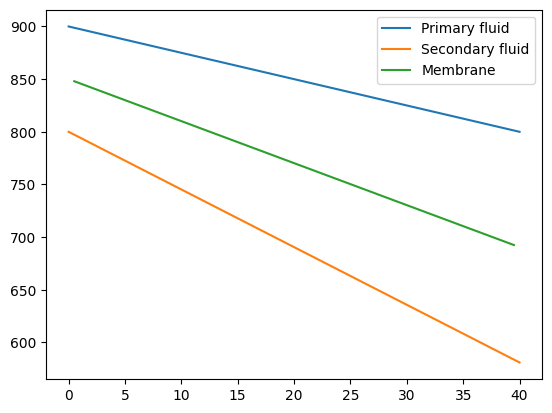

In [3]:

HX.get_global_HX_coeff(0)
circuit_HX=HX.split_HX(N=41,T_in_hot=BB.T_out,T_out_hot=BB.T_in,T_in_cold=581,T_out_cold=800,R_sec=1/HX.fluid.h_coeff,Q=BB.Q/n_pipes_HX,plotvar=True)


This vector is a Circuit class, with its functions, that we can exploit. With the get_eff_circuit method we get the extraction efficiency of the global circuit, but with a better T discretization.

In [4]:

circuit_HX.get_eff_circuit()
print(circuit_HX.eff)


0.0007609049658295424


With converge_split_HX we can get a plot of the global error in the efficiency with respect of the number of discretized components, so that we can check convergence happened. This method is a method of the Component class and not of Circuit.

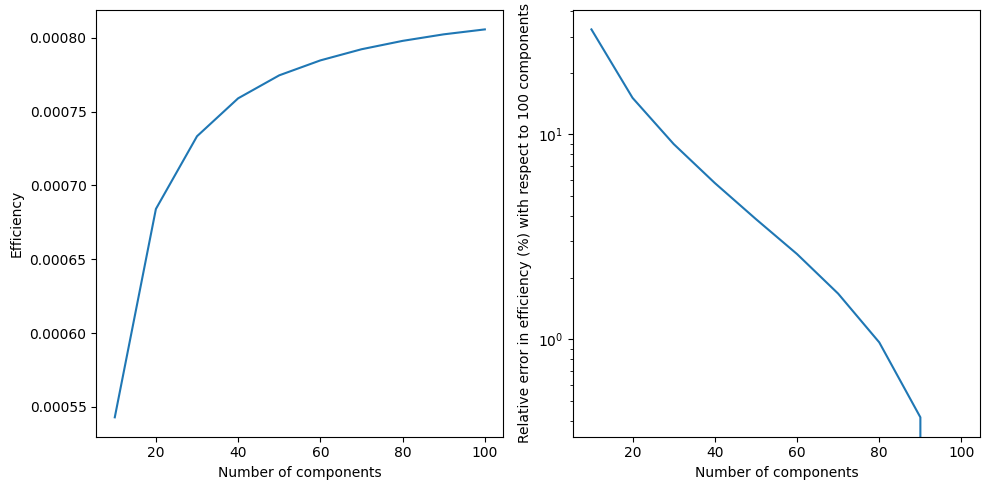

In [5]:

HX.converge_split_HX(T_in_hot=BB.T_out,T_out_hot=BB.T_in,T_in_cold=581,T_out_cold=800,R_sec=1/HX.fluid.h_coeff,Q=BB.Q/n_pipes_HX,plotvar=True)


With plot_circuit we get a fast plot of all the main variables of each component of a circuit

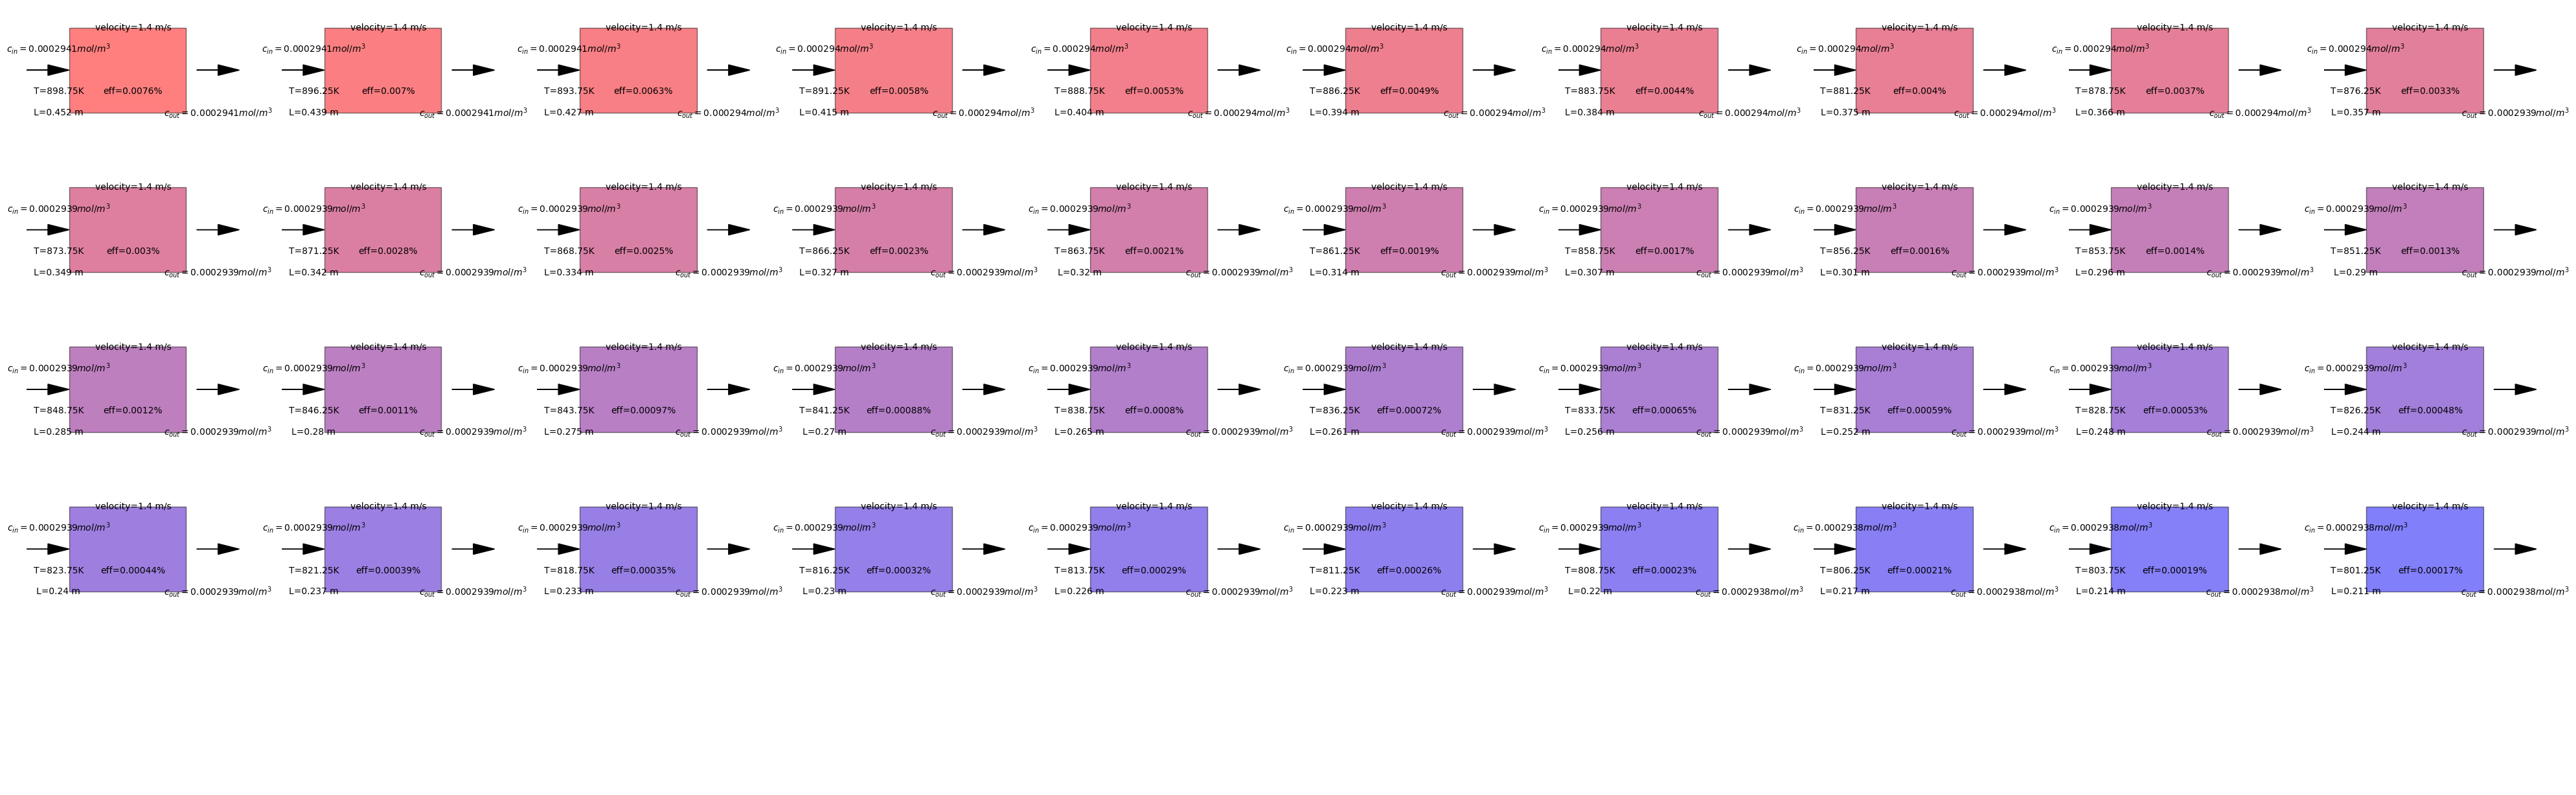

In [6]:

circuit_HX.plot_circuit()


We can also add the BB to the circuit, and define it as a closed loop trhough the circuit.closed boolean, then solve the loop. This calculation takes time as we are not extracting T efficiently, so the T concentration builds up in the circuit (and it takes several iterations to do this)

In [7]:
circuit_HX.add_component(BB)
circuit_HX.closed=True
circuit_HX.solve_circuit()
circuit_HX.plot_circuit()

We can define an extractor, add it to the circuit and solve the full circuit now

0.2550564469875343
extracted T amouts for the 99.83343467215853% of the total T
lost T amounts for the 0.16656532784146352 % of the total T


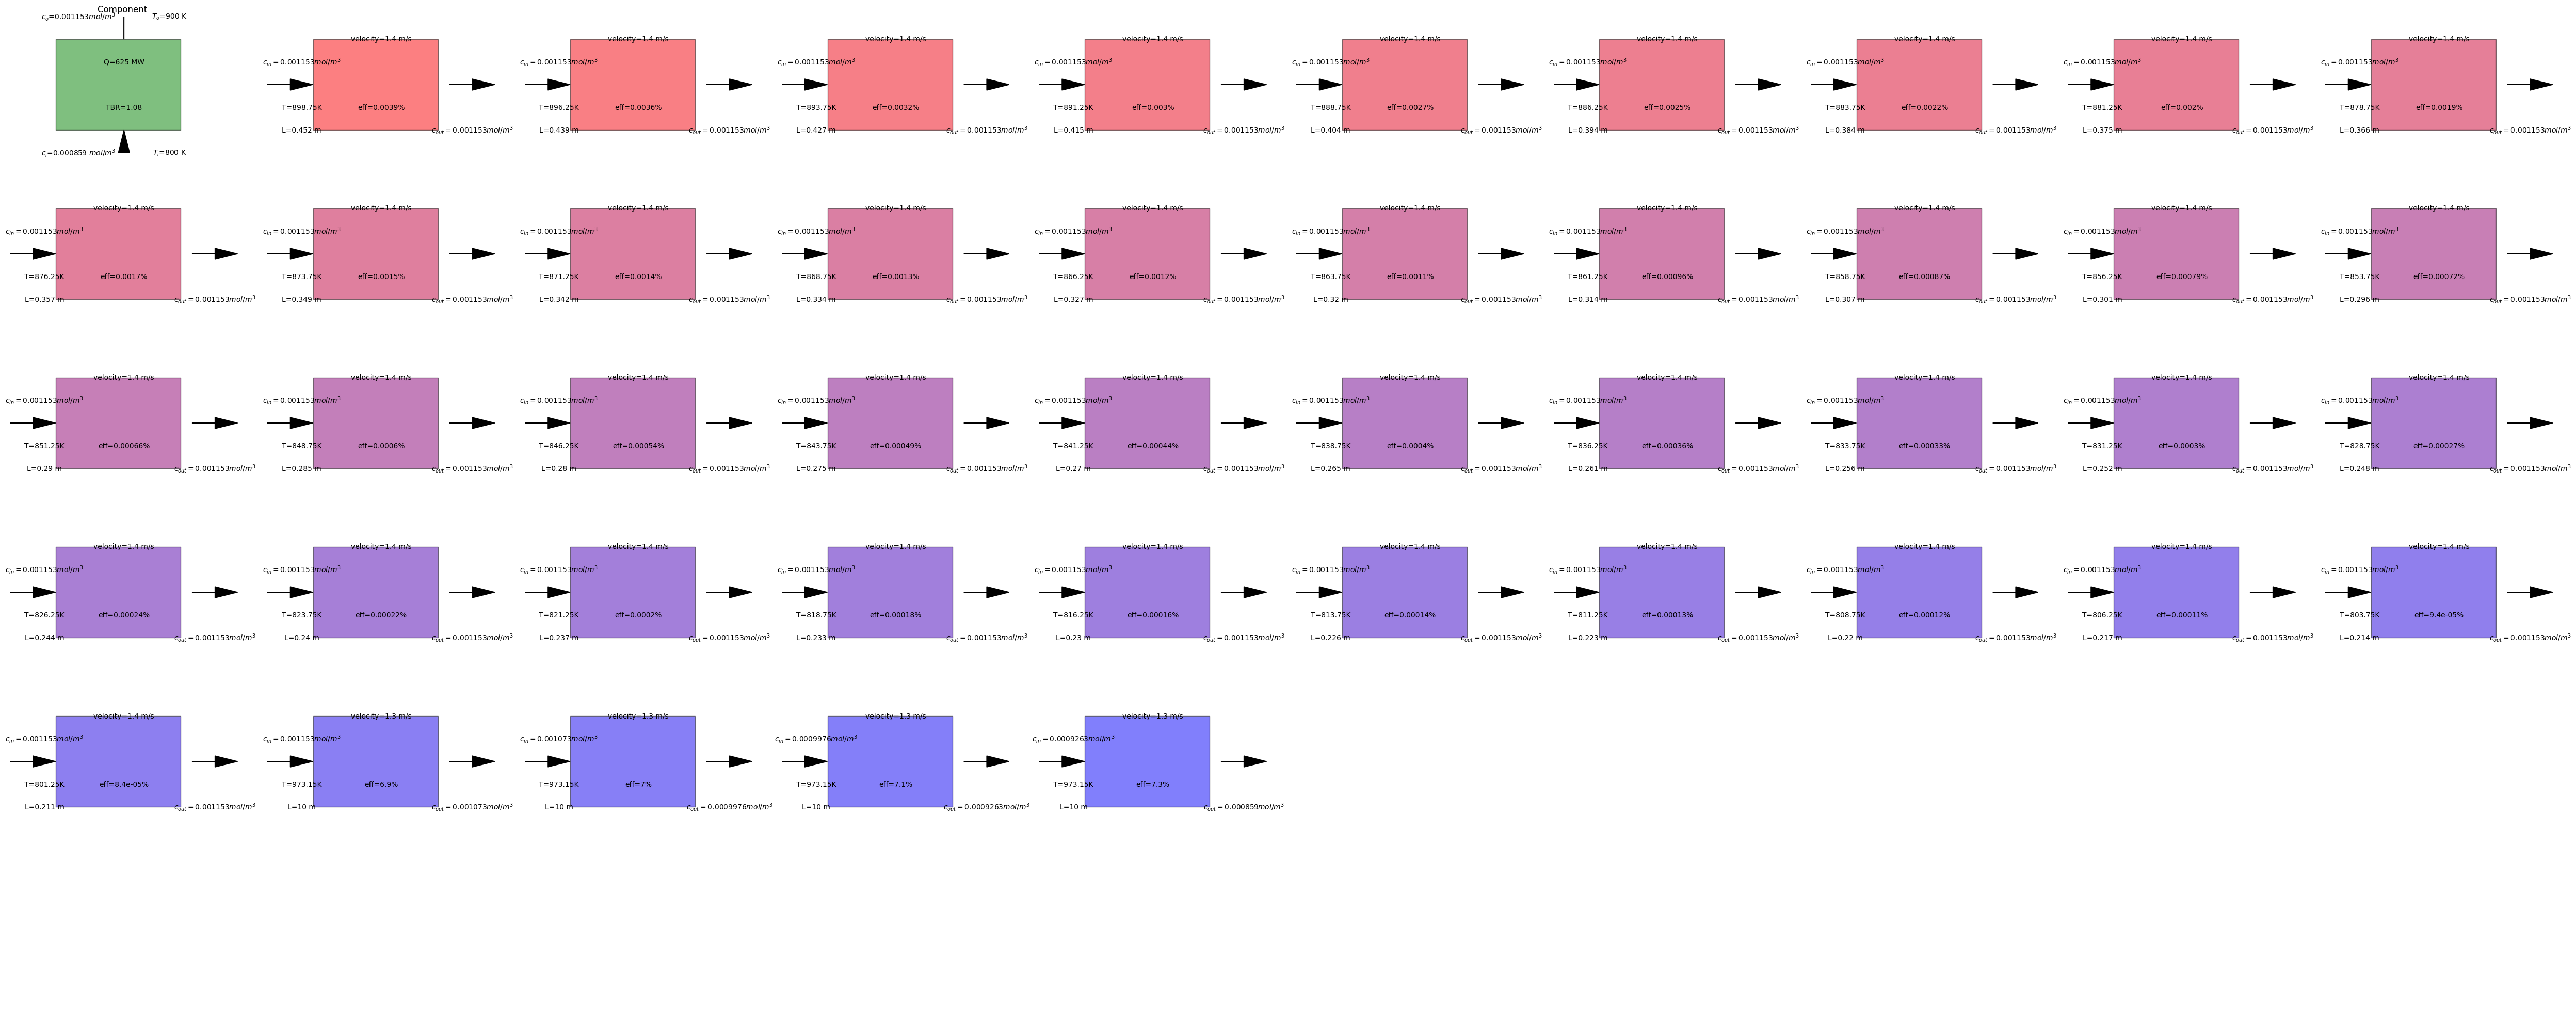

In [ ]:
geometry=Geometry(D=d_hyd,L=L,thick=0.25E-3)
flibe=Fluid(T=T, Solubility=k_H, MS=True,D=D_flibe, d_Hyd=d_hyd ,mu=mu_flibe,rho=rho_flibe,U0=U0,k=mat.k,
    cp=mat.cp)
PAV_geometry=Geometry(D=d_hyd,L=L,thick=0.25E-3)
PAV = Component(c_in=c_in,geometry=PAV_geometry, fluid=flibe, membrane=Steel, loss=False)
circuit_HX.add_component(PAV)
circuit_HX.solve_circuit()
circuit_HX.plot_circuit()
circuit_HX.get_gains_and_losses()
circuit_HX.get_eff_circuit()
print(circuit_HX.eff)
print("extracted T amounts for the "+str(circuit_HX.extraction_perc*100)+"% of the total T")
print("lost T amounts for the "+ str(circuit_HX.loss_perc*100)+" % of the total T")
